In [1]:
using DrWatson

In [2]:
@quickactivate
projectname()

"NowcastingHuascaran"

In [3]:
using PyCall
using Serialization
using ClimateBase
using Plots
using HDF5

In [4]:
const tf = pyimport("tensorflow")
const keras = pyimport("tensorflow.keras")

PyObject <module 'tensorflow.keras' from 'C:\\Users\\coolh\\miniconda3\\lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>

In [5]:
keras.__version__

"2.8.0"

In [6]:
repeat_elements = keras.backend.repeat_elements
expand_dims = keras.backend.expand_dims
keras_log = keras.backend.log

PyObject <function log at 0x00000000ABD005E0>

In [7]:
archs = readdir("../artifacts/experiments/"; join=true)

8-element Vector{String}:
 "../artifacts/experiments/Algo"
 "../artifacts/experiments/Input6" ⋯ 21 bytes ⋯ "2_3x3x48_Drop0.2_1x1x48_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 36 bytes ⋯ "2_3x3x64_Drop0.2_1x1x64_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 57 bytes ⋯ "_ConvLSTM2D1x1x64_Conv3D3x3x3x1"
 "../artifacts/experiments/Input64x64x8_5x5x64_3x3x64_1x1x16"
 "../artifacts/experiments/InputL" ⋯ 79 bytes ⋯ "TM2D8x64x64x64_Conv2D8x64x64x64"
 "../artifacts/experiments/current"
 "../artifacts/experiments/failed"

In [8]:
ds_path = datadir("exp_pro", "GLM-L2-LCFA_8km_5m_boxes", "2019", "jls")
ds = deserialize(readdir(ds_path; join=true)[1])

19-element Vector{<:ClimArray}:
 ClimArray (named flash_extent_density) with 64×64×288 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×32 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×25 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×47 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×135 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×132 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×103 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×76 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×117 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×97 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×30 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×27 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×110 Lon×Lat×Time data
 ClimArray (named flash_ex

In [60]:
function animation_comparation_prob(preds, grounds, fps; title=true)
    n = size(preds, 3)
    anim = @time @animate for i = 1:n
        pred = preds[:,:,i]
        ground = grounds[:,:,i]
        zerotonan(x) = x == 0 ? NaN : x
        
        h1 = heatmap(zerotonan.(pred), c=cgrad([:black, :white]), legend=false, clim=(0,1))
        heatmap!(zerotonan.(ground), c=cgrad([:black, :yellow]), legend=false, clim=(0,1))
        plot(h1, size=(480,480), title= title ? "Frame $i" : "")
    end
    gif(anim, fps=fps)
end

animation_comparation_prob (generic function with 1 method)

In [10]:
function animation_comparation(preds, grounds, fps)
    n = size(preds, 3)
    anim = @time @animate for i = 1:n
        pred = preds[:,:,i]
        ground = grounds[:,:,i]
        intersect_t = ground .≈ pred .≈ 1.0
        zerotonan(x) = x == 0 ? NaN : x
        
        h1 = heatmap(ground, c=cgrad([:black, :red]), legend=false, clim=(0,1))
        heatmap!(zerotonan.(pred), c=cgrad([:black, :white]), legend=false, clim=(0,1))
        heatmap!(zerotonan.(intersect_t), c=cgrad([:black, :blue]), legend=false, clim=(0,1))
        plot(h1, size=(480,480), title="Frame $i")
    end
    gif(anim, fps=fps)
end

animation_comparation (generic function with 1 method)

In [11]:
i = 6
@show size(ds[i])
dataset = copy(ds[i].data);

size(ds[i]) = (64, 64, 132)


In [12]:
archs

8-element Vector{String}:
 "../artifacts/experiments/Algo"
 "../artifacts/experiments/Input6" ⋯ 21 bytes ⋯ "2_3x3x48_Drop0.2_1x1x48_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 36 bytes ⋯ "2_3x3x64_Drop0.2_1x1x64_3x3x3x1"
 "../artifacts/experiments/Input6" ⋯ 57 bytes ⋯ "_ConvLSTM2D1x1x64_Conv3D3x3x3x1"
 "../artifacts/experiments/Input64x64x8_5x5x64_3x3x64_1x1x16"
 "../artifacts/experiments/InputL" ⋯ 79 bytes ⋯ "TM2D8x64x64x64_Conv2D8x64x64x64"
 "../artifacts/experiments/current"
 "../artifacts/experiments/failed"

In [15]:
i_arch = 6
models = readdir(archs[i_arch]; join=true)

2-element Vector{String}:
 "../artifacts/experiments/InputL" ⋯ 107 bytes ⋯ "x64\\saved-model-01-0.007682.h5"
 "../artifacts/experiments/InputL" ⋯ 107 bytes ⋯ "x64\\saved-model-02-0.007250.h5"

In [16]:
model = keras.models.load_model(
    models[1], 
    custom_objects = Dict("repeat_elements"=>repeat_elements, "expand_dims"=>expand_dims, "log" => keras_log)
)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 64, 64, 1)]   0         
                                                                 
 conv_lst_m2d_32 (ConvLSTM2D  (None, 16, 64, 64, 48)   235392    
 )                                                               
                                                                 
 conv_lst_m2d_33 (ConvLSTM2D  (None, 64, 64, 64)       258304    
 )                                                               
                                                                 
 lambda_8 (Lambda)           (None, 8, 64, 64, 64)     0         
                                                                 
 conv_lst_m2d_34 (ConvLSTM2D  (None, 8, 64, 64, 64)    33024     
 )                                                               
                                                           

In [65]:
model.get_layer("conv2d_8").get_weights()[1];

In [66]:
model.get_layer("conv2d_8").get_config()

Dict{Any, Any} with 19 entries:
  "trainable"            => true
  "groups"               => 1
  "strides"              => (1, 1)
  "bias_regularizer"     => nothing
  "activity_regularizer" => nothing
  "kernel_regularizer"   => nothing
  "data_format"          => "channels_last"
  "dtype"                => "float32"
  "name"                 => "conv2d_8"
  "padding"              => "same"
  "activation"           => "sigmoid"
  "dilation_rate"        => (1, 1)
  "use_bias"             => true
  "kernel_constraint"    => nothing
  "kernel_size"          => (3, 3)
  "kernel_initializer"   => Dict{Any, Any}("config"=>Dict{Any, Any}("seed"=>not…
  "filters"              => 64
  "bias_constraint"      => nothing
  "bias_initializer"     => Dict{Any, Any}("config"=>Dict{Any, Any}(), "class_n…

In [23]:
using Images

In [47]:
function transform_X(X)
    log.(X .+ 1)
end

transform_X (generic function with 1 method)

size(X) = (64, 64, 16)
size(predicted_y) = (1, 8, 64, 64, 64)
  0.258921 seconds (2.28 M allocations: 65.998 MiB)


┌ Info: Saved animation to 
│   fn = E:\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\LI4FE\src\animation.jl:114


Plots.AnimatedGif("E:\\nowcasting-huascaran\\notebooks\\tmp.gif")
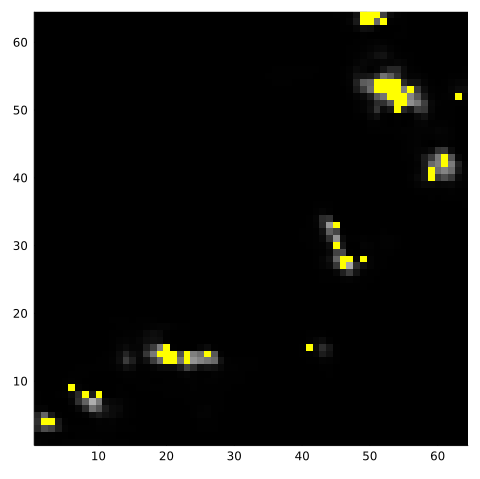

In [63]:
T_START = 60
TIME_IN = 16
TIME_OUT = 8
TIME_SKIP = 1
X = ds[i].data[:, :, T_START:T_START+TIME_IN-1]
y = ds[i].data[:, :, T_START+TIME_IN+TIME_SKIP-1:TIME_SKIP:end][:, :, begin:TIME_OUT]
@show size(X)
X = permutedims(reshape(X, (1, 64, 64, TIME_IN, 1)), (5,4,3,2,1))
X = transform_X(X)

predicted_y = model.predict(X)
@show size(predicted_y)
predicted_y = permutedims(predicted_y, reverse(1:ndims(predicted_y)))
predicted_y = predicted_y[1, :, :, :, 1]
#animation_comparation((predicted_y), y, 2)
anim = animation_comparation_prob(predicted_y, y, 2; title=false)

  0.300884 seconds (2.36 M allocations: 73.995 MiB, 9.24% gc time)


┌ Info: Saved animation to 
│   fn = E:\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\LI4FE\src\animation.jl:114


Plots.AnimatedGif("E:\\nowcasting-huascaran\\notebooks\\tmp.gif")
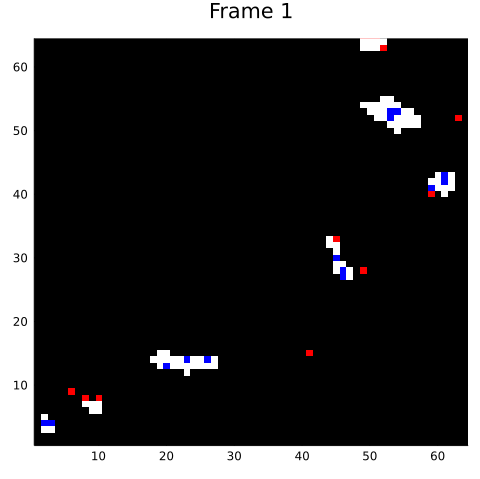

In [42]:
animation_comparation(predicted_y .> 0.25, y, 2)

In [30]:
using Flux

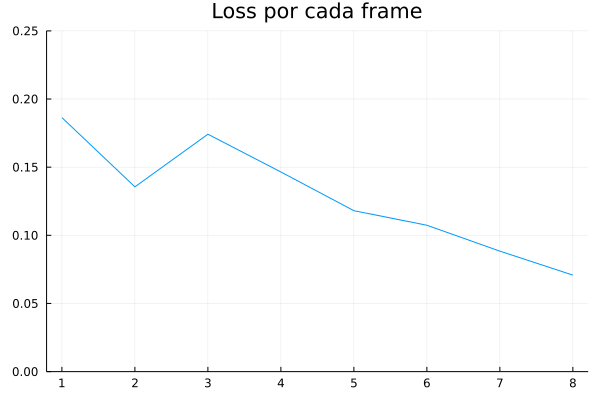

In [46]:
losses = Flux.Losses.crossentropy(predicted_y, y; dims=(1,2), agg=identity) ./ (64*64)
p = plot(losses[:], ylims=(0,.25), legend=false, xticks=1:32, title="Loss por cada frame")
savefig(p, "./plot_loss.png")
p

In [ ]:
# Balancear el conjunto de datos respecto al maximo de densidad de rayos
# Grafica de residuales o scatterplot (diferencia del target vs. predicho en eje y, eje x valor target)

In [ ]:
# [0, 1>
# [1, x>...

In [32]:
start = 50
X_ds, y = ds[i].data[:, :, start:start+n-1], ds[i].data[:, :, start+n:start+2n-1]
X = permutedims(reshape(X_ds, (1, 64, 64, 8, 1)), (5,4,3,2,1))
X_max = maximum(X)
ŷ = permutedims(model.predict(X / X_max), (5,4,3,2,1))
losses = [Flux.Losses.binarycrossentropy(ŷ[1,:,:,i,1], X_ds[:, :, i] / X_max) for i in 1:n]
plot(losses)

LoadError: UndefVarError: n not defined

In [ ]:
?Flux.Losses.binarycrossentropy